# Spatial Data

In [1]:
import pandas
import osmnx
import geopandas
import rioxarray
import xarray
import datashader
import contextily as cx
from shapely.geometry import box
import matplotlib.pyplot as plt

## Fundamentals

Geographic data is generally stored in a few distinct formats. As we discussed in the last chapter, these *data structures* are typically associated with *data models* that represent geographic processes. In what follows, we will get a little more familiar with the data structures that are involved in geographic data science. For each format, we will present the main concepts behind the data structure as well as the main patterns for working with data in that format. 

### Geographic Tables

To start, one common representation of geographic objects is the *geographic table* that represents a single geographic object as a row of a table. Each column in this table records information about the object. Typically, there is a special column in this table that records the *geometry* of the object. Computer systems that use this data structure are intended to add geography into a *relational database*, such as PostGreSQL (through its PostGIS extension) or sqlite (through its spatialite extension). Beyond this, however, many data science languages (such as R, Julia, and Python), have packages that adopt this data structure as well (such as sf, ArchGDAL, and geopandas), and it is rapidly becoming the main data structure for object-based geographic data. Geographic tables can be seen as a tab in a spreadsheet where one of the columns records geometric information.

Before proceeding, though, it helps to mention a quick clarification on terminology. Throughout this book, regardless of the data structure used, we will refer to a measurement about an observation as a *feature*. This is consistent with other work in data science and machine learning. Then, one set of measurements is a *sample*. For tables, this means a feature is a column and a sample is a row. Historically, though, geographic information scientists have used the word "feature" to mean an individual observation, since a "feature" in cartography is an entity on a map. Thus, being clear about this terminology is important: for this book, a *feature* is one measured trait pertaining to an observation (a column), and a *sample* is one set of measurements (a row). 

To understand the structure of these datasets, it will help to read in the `countries_clean.gpkg` dataset included in this book that describes countries in the world. To read in this data, we can use the `read_file()` method in `geopandas`:

In [2]:
gt_polygons = geopandas.read_file("../data/countries/countries_clean.gpkg")

And we can examine the top of the table with the method `.head()`:

In [3]:
gt_polygons.head()

,ADMIN,geometry
0,Indonesia,"MULTIPOLYGON (((13102705.696 463877.598, 13102..."
1,Malaysia,"MULTIPOLYGON (((13102705.696 463877.598, 13101..."
2,Chile,"MULTIPOLYGON (((-7737827.685 -1979875.500, -77..."
3,Bolivia,"POLYGON ((-7737827.685 -1979875.500, -7737828...."
4,Peru,"MULTIPOLYGON (((-7737827.685 -1979875.500, -77..."


Each row of this table is a single country. This table shows only two features: the administrative name of the country and the geometry of the country's boundary. The name of the country is encoded in the `ADMIN` column using the Python `str` type, which is used to store text-based data. The geometry of the country's boundary is stored in the `geometry` column, and is encoded using a special class in Python that is used to represent geometric objects. As with other table-based data structures in Python, every row and column have an index that identifies them uniquely and is rendered in bold. Geographic tables in Python are stored as `GeoDataFrame` objects.

Geographic tables store geographic information as an additional column. But, how is this information pertaining to each row encoded to store it? To clarify this, we can check the type of the object in the first row:

In [4]:
type(gt_polygons.geometry[0])

shapely.geometry.multipolygon.MultiPolygon

In `geopandas` (as well as other packages representing geographic data), sometimes the `geometry` column has special traits. For example, when we plot the dataframe, the `geometry` column is used as the main shape to use in the plot:

<AxesSubplot:>

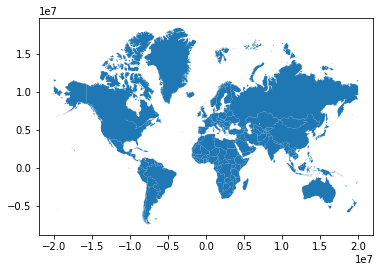

In [5]:
gt_polygons.plot()

Changing geometries must be done carefully: since the `geometry` column is special, there are special functions to adjust the geometry. For example, if we were to represent each country using its *centroid*, a point in the middle of the shape, then we must take care to set the geometry again. For example, when we compute the centroid, we can use the `gt_polygons.geometry.centroid` property and add a new column containing the centroid:

In [6]:
gt_polygons['centroid'] = gt_polygons.geometry.centroid

In [7]:
gt_polygons.head()

,ADMIN,geometry,centroid
0,Indonesia,"MULTIPOLYGON (((13102705.696 463877.598, 13102...",POINT (13055431.810 -248921.141)
1,Malaysia,"MULTIPOLYGON (((13102705.696 463877.598, 13101...",POINT (12211696.493 422897.505)
2,Chile,"MULTIPOLYGON (((-7737827.685 -1979875.500, -77...",POINT (-7959811.948 -4915458.802)
3,Bolivia,"POLYGON ((-7737827.685 -1979875.500, -7737828....",POINT (-7200010.945 -1894653.148)
4,Peru,"MULTIPOLYGON (((-7737827.685 -1979875.500, -77...",POINT (-8277554.831 -1032942.536)


We can switch to the centroid column using the `set_geometry()` method. This can be useful when you want to work with two different geometric representations of the same underlying sample. For example, we can plot the centroid and the boundary of each country by switching the geometry column with `set_geometry`: 

<AxesSubplot:>

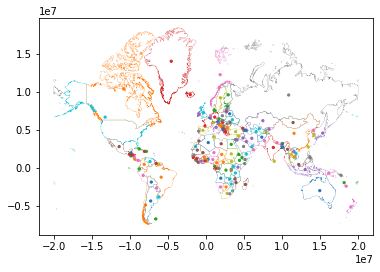

In [8]:
# Plot centroids
ax = gt_polygons.set_geometry('centroid')\
                .plot('ADMIN', 
                      markersize=5
                     )
# Plot polygons without color filling
gt_polygons.plot('ADMIN', 
                 ax=ax, 
                 facecolor='none', 
                 edgecolor='k', 
                 linewidth=.2
                )

Not how we can create a map by calling `.plot()` on a `GeoDataFrame`. We can color thematically each feature based on a given column by passing the name of that column to the plot engine (as we do on with `ADMIN` on this case).

Thus, as should now be clear, nearly any kind of geometric object can be represented in one (or more) geometry columns. Thinking about the number of different kinds of shapes or geometries one could draw quickly boggles the mind. Fortunately the Open Geospatial Consortium (OGC) has defined a set of "abstract" types that can be used to define any kind of geometry. This specification, codified in ISO 19125-1, the "simple features" specification, specifies the formal relationships between these types: a `Point` is a zero-dimensional location with an x and y coordinate; a `LineString` is a path composed of a set of more than one `Point`, and a `Polygon` is a surface that has  at least one LineString that starts and stops with the same coordinate. All of these types *also* have "Multi-" variants that indicate a collection of multiple geometries of the same type. So, for instance, Bolivia is represented as a single polygon:

In [9]:
gt_polygons.query('ADMIN == "Bolivia"')

,ADMIN,geometry,centroid
3,Bolivia,"POLYGON ((-7737827.685 -1979875.500, -7737828....",POINT (-7200010.945 -1894653.148)


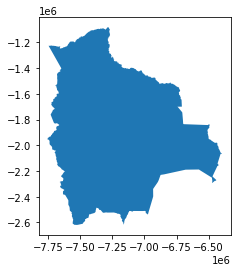

In [10]:
gt_polygons.query('ADMIN == "Bolivia"').plot();

while Indonesia is a `MultiPolygon` containing  many `Polygons` for each individual island in the country:

In [11]:
gt_polygons.query('ADMIN == "Indonesia"')

,ADMIN,geometry,centroid
0,Indonesia,"MULTIPOLYGON (((13102705.696 463877.598, 13102...",POINT (13055431.810 -248921.141)


<AxesSubplot:>

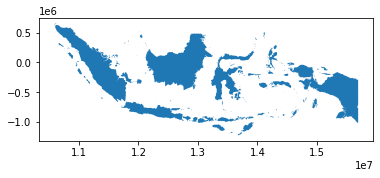

In [12]:
gt_polygons.query('ADMIN == "Indonesia"').plot()

Normally, geographic tables will only have geometries of a single type; records will *all* be `Point` or `LineString`, for instance. However, there is no formal requirement that a *geographic table* has geometries that all have the same type. 

Throughout this book, we will use geographic tables extensively, storing polygons, but also points and lines. We will explore lines a bit more in the second part of this chapter but, for now, let us stop on points for a second. As mentioned above, these are the simplest type of feature in that they do not have any dimension, only a pair of coordinates attached to them. This means that points can sometimes be stored in a non-geographic table, simply using one column for each coordinate. We find an example of this on the Tokyo dataset we will use later in this book. The data is stored as a comma-separated value table, or `.csv`:

In [13]:
points = pandas.read_csv("../data/tokyo/tokyo_clean.csv")

Since we have read it with `pandas`, the table is loaded as a `DataFrame`, with no explicit spatial dimension:

In [14]:
type(points)

pandas.core.frame.DataFrame

If we inspect the table, we find there is not a `geometry` column:

In [15]:
points.head()

,user_id,longitude,latitude,date_taken,photo/video_page_url,x,y
0,10727420@N00,139.700499,35.674000,2010-04-09 17:26:25.0,http://www.flickr.com/photos/10727420@N00/4545...,1.555139e+07,4.255856e+06
1,8819274@N04,139.766521,35.709095,2007-02-10 16:08:40.0,http://www.flickr.com/photos/8819274@N04/26503...,1.555874e+07,4.260667e+06
2,62068690@N00,139.765632,35.694482,2008-12-21 15:45:31.0,http://www.flickr.com/photos/62068690@N00/3125...,1.555864e+07,4.258664e+06
3,49503094041@N01,139.784391,35.548589,2011-11-11 05:48:54.0,http://www.flickr.com/photos/49503094041@N01/6...,1.556073e+07,4.238684e+06
4,40443199@N00,139.768753,35.671521,2006-04-06 16:42:49.0,http://www.flickr.com/photos/40443199@N00/2482...,1.555899e+07,4.255517e+06


Many point datasets are provided in this format. To make the most of them, it is convenient to convert them into `GeoDataFrame` tables. There are two steps involved in this process:

1. Turn coordinates into geometries:

In [16]:
pt_geoms = geopandas.points_from_xy(points["longitude"],
                                    points["latitude"],
                                    crs="EPSG:4326"
                                   )

2. Create a `GeoDataFrame` object:

In [17]:
gt_points = geopandas.GeoDataFrame(points,
                                   geometry=pt_geoms
                                  )

And now `gt_points` looks and feels exactly like the one of countries we have seen before, with the different the `geometry` column stores `POINT` geometries:

In [18]:
gt_points.head()

,user_id,longitude,latitude,date_taken,photo/video_page_url,x,y,geometry
0,10727420@N00,139.700499,35.674000,2010-04-09 17:26:25.0,http://www.flickr.com/photos/10727420@N00/4545...,1.555139e+07,4.255856e+06,POINT (139.70050 35.67400)
1,8819274@N04,139.766521,35.709095,2007-02-10 16:08:40.0,http://www.flickr.com/photos/8819274@N04/26503...,1.555874e+07,4.260667e+06,POINT (139.76652 35.70909)
2,62068690@N00,139.765632,35.694482,2008-12-21 15:45:31.0,http://www.flickr.com/photos/62068690@N00/3125...,1.555864e+07,4.258664e+06,POINT (139.76563 35.69448)
3,49503094041@N01,139.784391,35.548589,2011-11-11 05:48:54.0,http://www.flickr.com/photos/49503094041@N01/6...,1.556073e+07,4.238684e+06,POINT (139.78439 35.54859)
4,40443199@N00,139.768753,35.671521,2006-04-06 16:42:49.0,http://www.flickr.com/photos/40443199@N00/2482...,1.555899e+07,4.255517e+06,POINT (139.76875 35.67152)


### Surfaces

In [19]:
dem = xarray.open_rasterio("../data/nasadem/nasadem_sd.tif")

In [20]:
type(dem)

xarray.core.dataarray.DataArray

In [21]:
dem.attrs

{'transform': (0.0002777777777777778,
  0.0,
  -117.61125,
  0.0,
  -0.0002777777777777778,
  33.505138888888894),
 'crs': '+init=epsg:4326',
 'res': (0.0002777777777777778, 0.0002777777777777778),
 'is_tiled': 0,
 'nodatavals': (-32768.0,),
 'scales': (1.0,),
 'offsets': (0.0,),
 'AREA_OR_POINT': 'Area'}

In [22]:
dem.coords

Coordinates:
  * band     (band) int64 1
  * y        (y) float64 33.51 33.5 33.5 33.5 33.5 ... 32.53 32.53 32.53 32.53
  * x        (x) float64 -117.6 -117.6 -117.6 -117.6 ... -116.1 -116.1 -116.1

In [23]:
dem.sel(band=1)

<xarray.DataArray (y: 3515, x: 5510)>
[19367650 values with dtype=int16]
Coordinates:
    band     int64 1
  * y        (y) float64 33.51 33.5 33.5 33.5 33.5 ... 32.53 32.53 32.53 32.53
  * x        (x) float64 -117.6 -117.6 -117.6 -117.6 ... -116.1 -116.1 -116.1
Attributes:
    transform:      (0.0002777777777777778, 0.0, -117.61125, 0.0, -0.00027777...
    crs:            +init=epsg:4326
    res:            (0.0002777777777777778, 0.0002777777777777778)
    is_tiled:       0
    nodatavals:     (-32768.0,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area

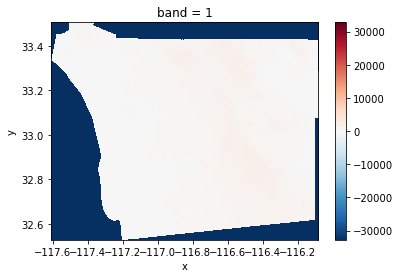

In [24]:
dem.sel(band=1).plot.imshow()

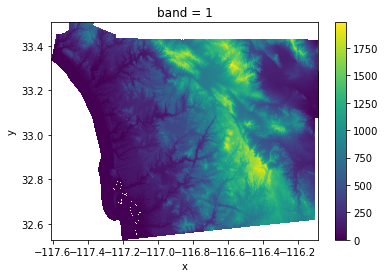

In [25]:
dem.where(dem>=0)\
   .sel(band=1)\
   .plot.imshow()

In [26]:
dem.attrs["crs"]

'+init=epsg:4326'

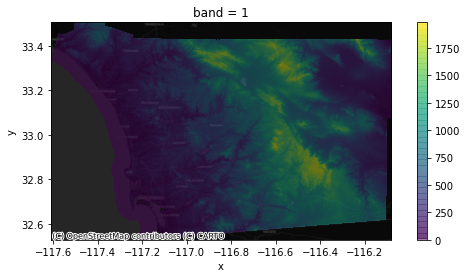

In [27]:
f, ax = plt.subplots(1, figsize=(9, 4))
dem.where(dem>=0)\
   .sel(band=1)\
   .plot.imshow(alpha=0.5)
cx.add_basemap(ax, 
               crs=dem.attrs["crs"], 
               source=cx.providers.CartoDB.DarkMatter, 
               zorder=-1,
              )

### Spatial graphs

In [28]:
%%time
graph = osmnx.graph_from_place("Yoyogi Park, Shibuya, Tokyo, Japan")

CPU times: user 987 ms, sys: 31.1 ms, total: 1.02 s
Wall time: 15.3 s


In [29]:
type(graph)

networkx.classes.multidigraph.MultiDiGraph

In [30]:
graph.size()

287

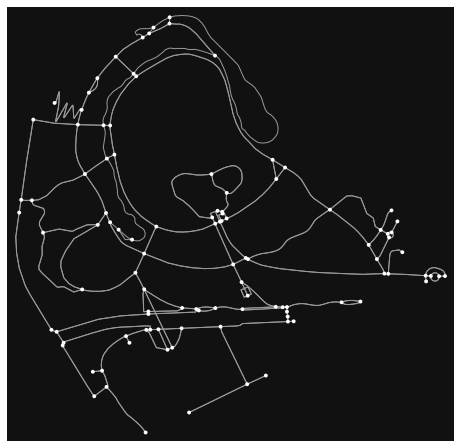

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [31]:
osmnx.plot_graph(graph)

## Hybrids

Technology is changing and sometimes objects may be best represented as surfaces, surfaces can be analysed as tables (+vectorization)

### Surfaces as tables

---

**`NOTE`** - replace with GHSL extract when ready

---

- Read surface

In [32]:
surface = xarray.open_rasterio("../data/nasadem/nasadem_sd.tif")

- Transfer to `pandas`

In [33]:
t_surface = surface.to_series()

- It's a standard tabular structure, we can use all we know about `pandas`!

In [34]:
t_surface.head()

band  y       x          
1     33.505  -117.611111   -32768
              -117.610833   -32768
              -117.610556   -32768
              -117.610278   -32768
              -117.610000   -32768
dtype: int16

In [35]:
t_surface = t_surface.reset_index().rename(columns={0: "Value"})

In [36]:
t_surface.head(2)

,band,y,x,Value
0,1,33.505,-117.611111,-32768
1,1,33.505,-117.610833,-32768


- If we want to convert the table into a geo-table

In [37]:
def row2cell(row, res_xy):
    res_x, res_y = res_xy
    minX = row["x"]
    maxX = row["x"] + res_x
    minY = row["y"] + res_y
    maxY = row["y"]
    poly = box(minX, minY, maxX, maxY)
    return poly

- For example, we can pull out cells higher than 1850m and create a geo-table with those

In [38]:
max_polys = t_surface.query("Value > 1850")\
                     .apply(row2cell, 
                            res_xy=surface.attrs["res"], 
                            axis=1
                           )
max_polys = geopandas.GeoSeries(max_polys, crs="EPSG:4326")

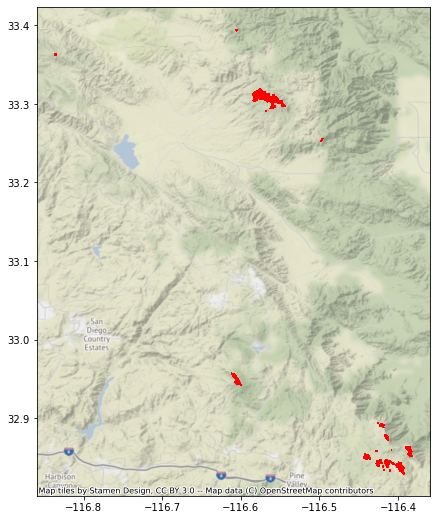

In [39]:
ax = max_polys.plot(edgecolor="red", 
                    figsize=(9, 9)
                   )
cx.add_basemap(ax, 
               alpha=0.75, 
               crs="EPSG:4326", 
               source=cx.providers.Stamen.Terrain
              )

We can also use the data with our favorite analytics library that relies on `pandas` (e.g. `sklearn`, `statsmodels`, `pysal`)

- Convert back to `xarray`

In [41]:
new_da = xarray.DataArray.from_series(t_surface.set_index(["band", "y", "x"])["Value"])
new_da

<xarray.DataArray 'Value' (band: 1, y: 3515, x: 5510)>
array([[[-32768, -32768, -32768, ..., -32768, -32768, -32768],
        [-32768, -32768, -32768, ..., -32768, -32768, -32768],
        [-32768, -32768, -32768, ..., -32768, -32768, -32768],
        ...,
        [-32768, -32768, -32768, ..., -32768, -32768, -32768],
        [-32768, -32768, -32768, ..., -32768, -32768, -32768],
        [-32768, -32768, -32768, ..., -32768, -32768, -32768]]],
      dtype=int16)
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 32.53 32.53 32.53 32.53 32.53 ... 33.5 33.5 33.5 33.51
  * x        (x) float64 -117.6 -117.6 -117.6 -117.6 ... -116.1 -116.1 -116.1

### Tables as surfaces

Discuss cases where, for example you have so many points that there are more than pixels in the screen. Here it makes sense, computationally and conceptually, to aggregate in fine geographies such as grids and store/represent them as such.

Use Tokyo photographs as example for a gridding (e.g. using datashader, which returns `DataArray` objects).

<AxesSubplot:>

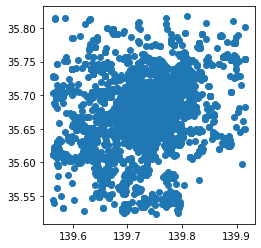

In [42]:
gt_points.plot()

In [43]:
cvs = datashader.Canvas(plot_width=60,
                        plot_height=60
                       )
grid = cvs.points(gt_points, 
                  x="longitude", 
                  y="latitude"
                 )
grid

<xarray.DataArray (latitude: 60, longitude: 60)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [2, 0, 0, ..., 0, 0, 0]], dtype=uint32)
Coordinates:
  * longitude  (longitude) float64 139.6 139.6 139.6 139.6 ... 139.9 139.9 139.9
  * latitude   (latitude) float64 35.53 35.53 35.54 35.54 ... 35.81 35.81 35.82

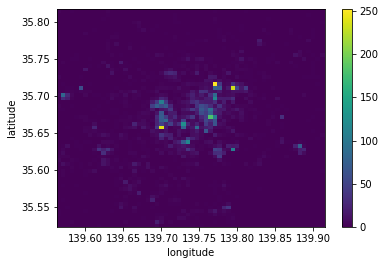

In [44]:
grid.plot()

### Networks as graphs *and* tables

Pick up on the discussion in the last paragraph of [this](https://geographicdata.science/book/notebooks/02_spatial_data.html#computational-represenations-data-structures) and illustrate how a street network can be represented as a graph or a table, what are the data structures in Python for each and how to go from one to the other.

In [45]:
gt_intersections, gt_lines = osmnx.graph_to_gdfs(graph)

---
# Questions

1. One way to convert from `Multi-`type geometries into many individual geometries is using the `explode()` method of a GeoDataFrame. Using the `explode()` method, how many islands are in Indonesia?

In [ ]:
gt_polygons.query('ADMIN == "Indonesia"').explode()